<a href="https://colab.research.google.com/github/chrisliii/FINE-452/blob/main/M%26A_CAPM_FF3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance

     |████████████████████████████████| 5.5MB 3.8MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22618 sha256=320c3e4a5b5d4ab69582b2c191f18f3f4531fdb2881de886b7f82c38b8991624
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
import statsmodels.api as sm
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
stock_name = "BUD"
ticker = yf.Ticker(stock_name)
#ticker.info
# monthly data
df_ticker_monthly_return = ticker.history(period="max", interval='1mo')
# process Dividends
df_ticker_monthly_return = df_ticker_monthly_return.dropna(how='all')
df_ticker_monthly_return['Dividends'] = df_ticker_monthly_return['Dividends'].shift(1)
df_ticker_monthly_return = df_ticker_monthly_return.dropna()
# monthly return
df_ticker_monthly_return['MonthlyReturn'] = 100*( (df_ticker_monthly_return['Close'].shift(-1)+df_ticker_monthly_return['Dividends'].shift(-1)).div(df_ticker_monthly_return['Close']) - 1)
df_ticker_monthly_return = df_ticker_monthly_return.dropna()
#date to string
df_ticker_monthly_return = df_ticker_monthly_return.reset_index()
df_ticker_monthly_return['Date'] = df_ticker_monthly_return['Date'].apply(lambda x: x.strftime('%Y%m'))

df_ticker_monthly_return.head(5)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,MonthlyReturn
0,200908,29.760937,32.774703,28.668446,32.699360,552600.0,0.0,0,5.852513
1,200909,32.021257,36.097375,31.192473,34.613094,5235600.0,0.0,0,2.699178
2,200910,33.859653,39.585809,32.714422,35.547363,6638200.0,0.0,0,6.591803
3,200911,36.089851,39.593352,34.869273,37.890575,9535400.0,0.0,0,3.459925
4,200912,38.425517,40.452274,37.860436,39.201561,4094100.0,0.0,0,-4.305201


In [5]:
df_FF_Research = pd.read_csv('F-F_Research_Data_Factors.CSV', encoding="utf-8", skipinitialspace=True)
df_FF_Research.columns = ['Date', 'Mkt-RF', 'SMB', 'HML', 'RF']
df_FF_Research = df_FF_Research.dropna()
df_FF_Research['Mkt-RF'] = df_FF_Research['Mkt-RF'].astype(float)
df_FF_Research['SMB'] = df_FF_Research['SMB'].astype(float)
df_FF_Research['HML'] = df_FF_Research['HML'].astype(float)

df_FF_Research.head()

,Date,Mkt-RF,SMB,HML,RF
0,192607,2.96,-2.30,-2.87,0.22
1,192608,2.64,-1.40,4.19,0.25
2,192609,0.36,-1.32,0.01,0.23
3,192610,-3.24,0.04,0.51,0.32
4,192611,2.53,-0.20,-0.35,0.31


In [ ]:
# Before merger
df_ticker_FF = pd.merge(df_ticker_monthly_return, df_FF_Research, on='Date')
df_ticker_FF['Date'] = df_ticker_FF['Date'].astype(int)
df_ticker_FF = df_ticker_FF[(df_ticker_FF.Date >= 201009) & 
                            (df_ticker_FF.Date <= 201509)]

model = sm.OLS(df_ticker_FF['MonthlyReturn'], sm.add_constant(
    df_ticker_FF[['Mkt-RF', 'SMB', 'HML']].values))
result = model.fit()
print(stock_name + '\n')
print (result.params)
print(result.summary())

BUD

const    0.429189
x1       1.016587
x2      -0.338834
x3      -0.529946
dtype: float64
                            OLS Regression Results                            
Dep. Variable:          MonthlyReturn   R-squared:                       0.393
Model:                            OLS   Adj. R-squared:                  0.361
Method:                 Least Squares   F-statistic:                     12.31
Date:                Wed, 28 Oct 2020   Prob (F-statistic):           2.57e-06
Time:                        04:59:11   Log-Likelihood:                -175.71
No. Observations:                  61   AIC:                             359.4
Df Residuals:                      57   BIC:                             367.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

In [ ]:
# After merger
df_ticker_FF = pd.merge(df_ticker_monthly_return, df_FF_Research, on='Date')
df_ticker_FF['Date'] = df_ticker_FF['Date'].astype(int)
df_ticker_FF = df_ticker_FF[(df_ticker_FF.Date >= 201511) & 
                            (df_ticker_FF.Date <= 202011)]

model = sm.OLS(df_ticker_FF['MonthlyReturn'], sm.add_constant(
    df_ticker_FF[['Mkt-RF', 'SMB', 'HML']].values))
result = model.fit()
print(stock_name + '\n')
print (result.params)
print(result.summary())

BUD

const   -1.665961
x1       1.312990
x2      -0.389646
x3       0.122467
dtype: float64
                            OLS Regression Results                            
Dep. Variable:          MonthlyReturn   R-squared:                       0.412
Model:                            OLS   Adj. R-squared:                  0.379
Method:                 Least Squares   F-statistic:                     12.39
Date:                Wed, 28 Oct 2020   Prob (F-statistic):           2.97e-06
Time:                        04:59:12   Log-Likelihood:                -188.25
No. Observations:                  57   AIC:                             384.5
Df Residuals:                      53   BIC:                             392.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

In [5]:
# past period rolling

# data prep
df_ticker_FF = pd.merge(df_ticker_monthly_return, df_FF_Research, on='Date')
df_ticker_FF['Date'] = pd.to_datetime(df_ticker_FF['Date'], format='%Y%m')

# sample period
begin_date = datetime(2010, 10, 1)
end_date = datetime(2020, 7, 1)
sample_period = 36

# CAPM out of sample
sample_date = begin_date
while sample_date <= end_date:
  df_ticker_FF_sample = df_ticker_FF[(df_ticker_FF.Date >= (sample_date - relativedelta(months=sample_period)) ) & 
                                     (df_ticker_FF.Date < sample_date)].copy()
  CAPM_model = sm.OLS(df_ticker_FF_sample['MonthlyReturn'], sm.add_constant(df_ticker_FF_sample[['Mkt-RF']].values))
  CAPM_result = CAPM_model.fit()
  #print(stock_name + '\n')
  #print (result.params)
  #print(CAPM_result.summary())

  # predict 
  sample_input = df_ticker_FF[(df_ticker_FF.Date == sample_date)]
  sample_input = sample_input['Mkt-RF'].values[0]
  sample_pred =  CAPM_result.predict([1,sample_input])
  #print(sample_input)
  #print(sample_pred)
  df_ticker_FF.loc[df_ticker_FF.Date == sample_date, 'PredReturn'] = sample_pred[0]

  # next sample
  sample_date = sample_date + relativedelta(months=1)


df_ticker_FF = df_ticker_FF.dropna()

df_ticker_FF.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,MonthlyReturn,Mkt-RF,SMB,HML,RF,PredReturn
14,2010-10-01,44.969899,49.292607,43.615247,47.869465,25527800.0,0.0,0,-12.655023,3.88,1.13,-2.61,0.01,2.118915
15,2010-11-01,48.166264,48.569615,41.453886,41.811573,24626900.0,0.0,0,3.913371,0.60,3.71,-0.90,0.01,2.361914
16,2010-12-01,42.481293,44.520882,42.374748,43.447815,20067700.0,0.0,0,-3.117884,6.82,0.68,3.81,0.01,-0.289852
17,2011-01-01,43.858777,44.810078,41.788745,42.093163,19419700.0,0.0,0,1.301739,1.99,-2.47,0.81,0.01,1.675131
18,2011-02-01,42.268197,43.234719,41.400612,42.641106,30938900.0,0.0,0,2.034619,3.49,1.53,1.09,0.01,0.937441


In [7]:
# past period accumulative

# data prep
df_ticker_FF = pd.merge(df_ticker_monthly_return, df_FF_Research, on='Date')
df_ticker_FF['Date'] = pd.to_datetime(df_ticker_FF['Date'], format='%Y%m')

# sample period
begin_date = datetime(2010, 10, 1)
end_date = datetime(2020, 7, 1)
sample_period = 60

# CAPM out of sample
sample_date = begin_date
while sample_date <= end_date:
  df_ticker_FF_sample = df_ticker_FF[(df_ticker_FF.Date >= (begin_date - relativedelta(months=sample_period)) ) & 
                                     (df_ticker_FF.Date < sample_date)].copy()
  CAPM_model = sm.OLS(df_ticker_FF_sample['MonthlyReturn'], sm.add_constant(df_ticker_FF_sample[['Mkt-RF']].values))
  CAPM_result = CAPM_model.fit()
  #print(stock_name + '\n')
  #print (result.params)
  #print(CAPM_result.summary())

  # predict 
  sample_input = df_ticker_FF[(df_ticker_FF.Date == sample_date)]
  sample_input = sample_input['Mkt-RF'].values[0]
  sample_pred =  CAPM_result.predict([1,sample_input])
  #print(sample_input)
  #print(sample_pred)
  df_ticker_FF.loc[df_ticker_FF.Date == sample_date, 'PredReturn'] = sample_pred[0]

  # next sample
  sample_date = sample_date + relativedelta(months=1)


df_ticker_FF = df_ticker_FF.dropna()

df_ticker_FF.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,MonthlyReturn,Mkt-RF,SMB,HML,RF,PredReturn
14,2010-10-01,44.969899,49.292607,43.615247,47.869465,25527800.0,0.0,0,-12.655023,3.88,1.13,-2.61,0.01,2.118915
15,2010-11-01,48.166264,48.569615,41.453886,41.811573,24626900.0,0.0,0,3.913371,0.60,3.71,-0.90,0.01,2.361914
16,2010-12-01,42.481293,44.520882,42.374748,43.447815,20067700.0,0.0,0,-3.117884,6.82,0.68,3.81,0.01,-0.289852
17,2011-01-01,43.858777,44.810078,41.788745,42.093163,19419700.0,0.0,0,1.301739,1.99,-2.47,0.81,0.01,1.675131
18,2011-02-01,42.268197,43.234719,41.400612,42.641106,30938900.0,0.0,0,2.034619,3.49,1.53,1.09,0.01,0.937441


In [8]:
df_ticker_FF['AbsEpsilon'] = abs(df_ticker_FF.MonthlyReturn - df_ticker_FF.PredReturn)
# RollingAvgEpsilon
df_ticker_FF['RollingAvgEpsilon'] = df_ticker_FF.AbsEpsilon.rolling(20).mean()
# CumAvgEpsilon
for date in df_ticker_FF[df_ticker_FF.Date >= begin_date + relativedelta(months=12)].Date.tolist():
  df_ticker_FF.loc[df_ticker_FF.Date == date, 'CumAvgEpsilon'] = df_ticker_FF[df_ticker_FF.Date <= date].AbsEpsilon.mean()

df_ticker_FF.tail()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,MonthlyReturn,Mkt-RF,SMB,HML,RF,PredReturn,AbsEpsilon,RollingAvgEpsilon,CumAvgEpsilon
127,2020-03-01,56.933184,58.101959,32.270064,43.700279,111428900.0,0.000,0,5.439715,-13.39,-5.15,-14.17,0.12,1.905664,3.534050,9.801113,5.597736
128,2020-04-01,43.957808,49.464913,40.718916,46.077450,54805900.0,0.000,0,0.773860,13.65,2.76,-1.18,0.00,-0.569686,1.343546,9.513318,5.560743
129,2020-05-01,45.958592,47.890038,37.569167,46.434025,63894000.0,0.000,0,5.162112,5.58,2.46,-4.92,0.01,0.330863,4.831249,8.905128,5.554455
130,2020-06-01,47.374988,58.101959,47.008505,48.831001,70354500.0,0.000,0,12.594456,2.45,2.68,-2.19,0.01,0.688672,11.905784,9.426294,5.608739
131,2020-07-01,48.410000,58.549999,48.410000,54.430000,45817800.0,0.551,0,6.834468,5.77,-2.31,-1.27,0.01,0.520770,6.313699,9.081636,5.614714


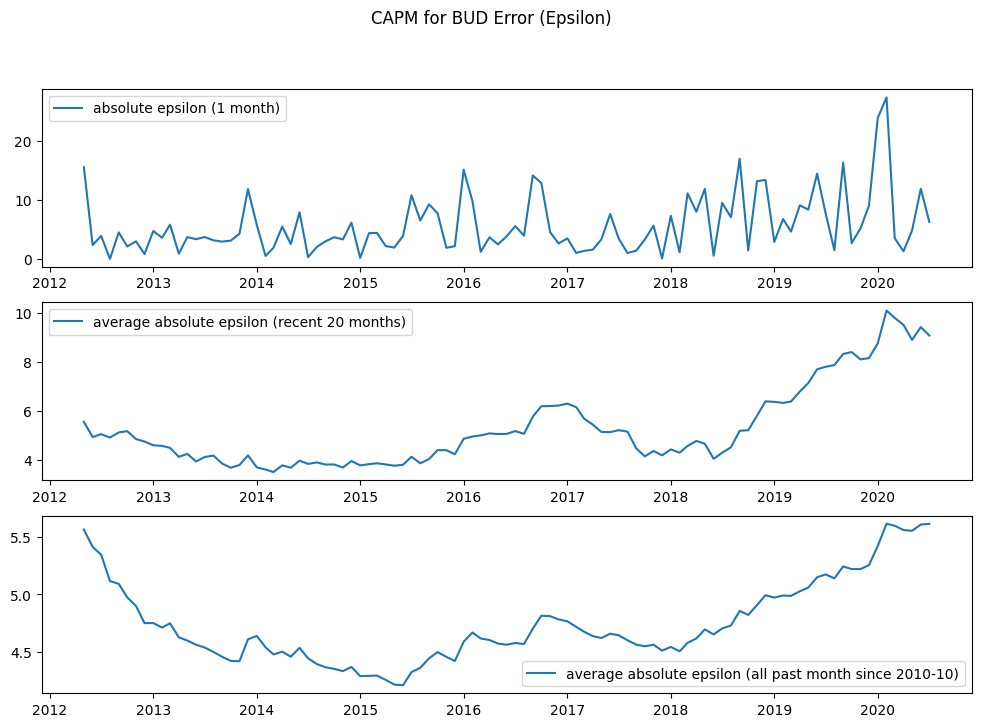

In [9]:
df_ticker_FF = df_ticker_FF.dropna()

fig, (ax1, ax2, ax3) = plt.subplots(3, dpi=100, figsize=(12,8))
fig.suptitle('CAPM for BUD Error (Epsilon)')
ax1.plot(df_ticker_FF.Date, df_ticker_FF.AbsEpsilon, label='absolute epsilon (1 month)')
ax1.legend()
ax2.plot(df_ticker_FF.Date, df_ticker_FF.RollingAvgEpsilon, label='average absolute epsilon (recent 20 months)')
ax2.legend()
ax3.plot(df_ticker_FF.Date, df_ticker_FF.CumAvgEpsilon, label='average absolute epsilon (all past month since 2010-10)')
ax3.legend()

In [6]:
# past period accumulative

# data prep
df_ticker_FF = pd.merge(df_ticker_monthly_return, df_FF_Research, on='Date')
df_ticker_FF['Date'] = pd.to_datetime(df_ticker_FF['Date'], format='%Y%m')

# sample period
begin_date = datetime(2010, 10, 1)
end_date = datetime(2020, 7, 1)
sample_period = 120

# FF3 out of sample
sample_date = begin_date
while sample_date <= end_date:
  df_ticker_FF_sample = df_ticker_FF[(df_ticker_FF.Date >= (begin_date - relativedelta(months=sample_period)) ) & 
                                     (df_ticker_FF.Date < sample_date)].copy()
  FF3_model = sm.OLS(df_ticker_FF_sample['MonthlyReturn'], 
                      sm.add_constant(df_ticker_FF_sample[['Mkt-RF', 'SMB', 'HML']].values))
  FF3_result = FF3_model.fit()
  #print(stock_name + '\n')
  #print (FF3_result.params)
  #print(FF3_result.summary())

  # predict 
  sample_input = df_ticker_FF[(df_ticker_FF.Date == sample_date)]
  sample_input = sample_input[['Mkt-RF', 'SMB', 'HML']].values[0].tolist()
  sample_pred =  FF3_result.predict([1] + sample_input)
  #print(sample_input)
  #print(sample_pred)
  df_ticker_FF.loc[df_ticker_FF.Date == sample_date, 'PredReturn'] = sample_pred[0]

  # next sample
  sample_date = sample_date + relativedelta(months=1)


df_ticker_FF = df_ticker_FF.dropna()

df_ticker_FF.head()

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  "anyway, n=%i" % int(n))
/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))
/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))
/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))
/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))
/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % 

                            OLS Regression Results                            
Dep. Variable:          MonthlyReturn   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.181
Method:                 Least Squares   F-statistic:                     1.961
Date:                Wed, 04 Nov 2020   Prob (F-statistic):              0.184
Time:                        19:50:59   Log-Likelihood:                -39.054
No. Observations:                  14   AIC:                             86.11
Df Residuals:                      10   BIC:                             88.66
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.5497      1.304      2.723      0.0

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,MonthlyReturn,Mkt-RF,SMB,HML,RF,PredReturn
14,2010-10-01,44.969899,49.292607,43.615247,47.869465,25527800.0,0.0,0,-12.655023,3.88,1.13,-2.61,0.01,3.179033
15,2010-11-01,48.166264,48.569615,41.453886,41.811573,24626900.0,0.0,0,3.913371,0.60,3.71,-0.90,0.01,-0.579923
16,2010-12-01,42.481293,44.520882,42.374748,43.447815,20067700.0,0.0,0,-3.117884,6.82,0.68,3.81,0.01,0.874377
17,2011-01-01,43.858777,44.810078,41.788745,42.093163,19419700.0,0.0,0,1.301739,1.99,-2.47,0.81,0.01,3.894498
18,2011-02-01,42.268197,43.234719,41.400612,42.641106,30938900.0,0.0,0,2.034619,3.49,1.53,1.09,0.01,0.581515


In [29]:
df_ticker_FF['AbsEpsilon'] = abs(df_ticker_FF.MonthlyReturn - df_ticker_FF.PredReturn)
# RollingAvgEpsilon
df_ticker_FF['RollingAvgEpsilon'] = df_ticker_FF.AbsEpsilon.rolling(20).mean()
# CumAvgEpsilon
for date in df_ticker_FF[df_ticker_FF.Date >= begin_date + relativedelta(months=12)].Date.tolist():
  df_ticker_FF.loc[df_ticker_FF.Date == date, 'CumAvgEpsilon'] = df_ticker_FF[df_ticker_FF.Date <= date].AbsEpsilon.mean()

df_ticker_FF.tail()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,MonthlyReturn,Mkt-RF,SMB,HML,RF,PredReturn,AbsEpsilon,RollingAvgEpsilon,CumAvgEpsilon
127,2020-03-01,56.933184,58.101959,32.270064,43.700279,111428900.0,0.000,0,5.439715,-13.39,-5.15,-14.17,0.12,1.058614,4.381101,9.836596,5.705090
128,2020-04-01,43.957808,49.464913,40.718916,46.077450,54805900.0,0.000,0,0.773860,13.65,2.76,-1.18,0.00,-0.473315,1.247175,9.522963,5.666325
129,2020-05-01,45.958592,47.890038,37.569167,46.434025,63896700.0,0.000,0,5.162112,5.58,2.46,-4.92,0.01,1.120779,4.041334,8.906731,5.652317
130,2020-06-01,47.374988,58.101959,47.008505,48.831001,70354500.0,0.000,0,12.594456,2.45,2.68,-2.19,0.01,1.734506,10.859950,9.329686,5.696826
131,2020-07-01,48.410000,58.549999,48.410000,54.430000,45817800.0,0.551,0,6.834468,5.77,-2.31,-1.27,0.01,-0.754656,7.589125,9.064627,5.712863


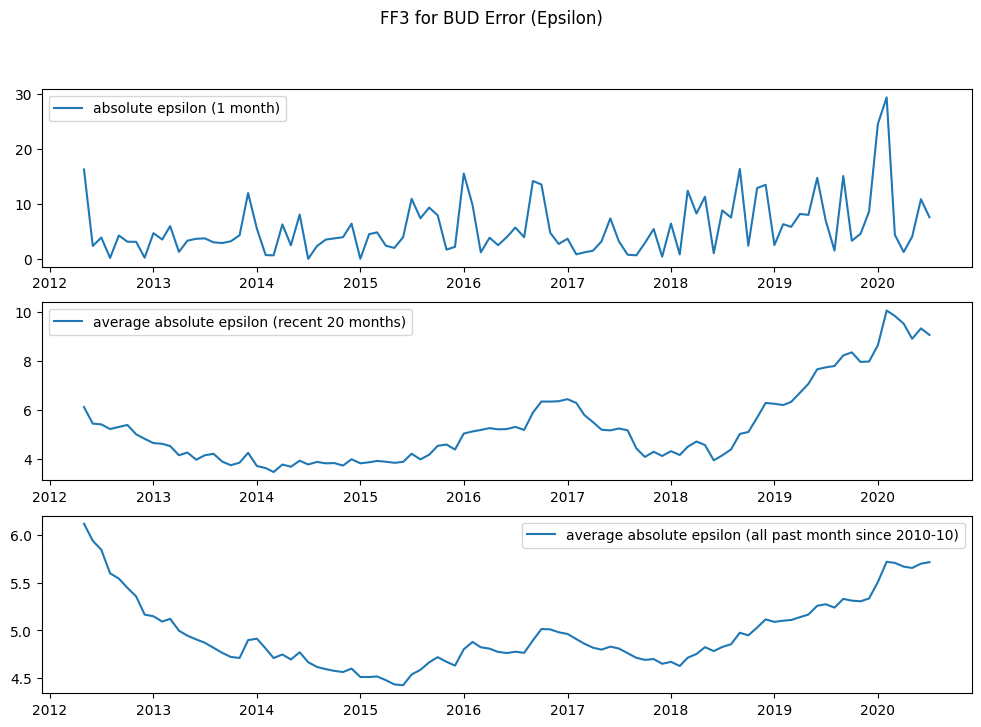

In [30]:
df_ticker_FF = df_ticker_FF.dropna()

fig, (ax1, ax2, ax3) = plt.subplots(3, dpi=100, figsize=(12,8))
fig.suptitle('FF3 for BUD Error (Epsilon)')
ax1.plot(df_ticker_FF.Date, df_ticker_FF.AbsEpsilon, label='absolute epsilon (1 month)')
ax1.legend()
ax2.plot(df_ticker_FF.Date, df_ticker_FF.RollingAvgEpsilon, label='average absolute epsilon (recent 20 months)')
ax2.legend()
ax3.plot(df_ticker_FF.Date, df_ticker_FF.CumAvgEpsilon, label='average absolute epsilon (all past month since 2010-10)')
ax3.legend()